In [75]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import imageio
from PIL import Image
from numpy.ma import masked_array
%run -i main.ipynb

### $$\textbf{Data acquisition}$$
<hr>

Transmission image


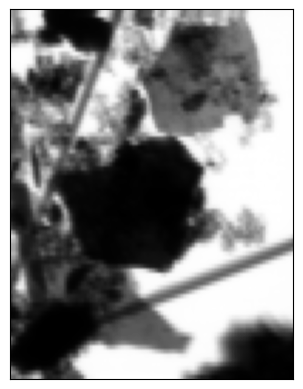

In [85]:
#loading transmission data
filename='MPI_210723146'
f=h5py.File(filename+'.hdf','r')
energy=f['exchange/energy'][...]
data_trans=np.transpose((f['exchange/data'][...]),(1,0,2))
#print(list(f.keys()))
print('Transmission image')
data_trans_unfold=data_trans.reshape(data_trans.shape[0]* data_trans.shape[1], data_trans.shape[2])
resox=0.1
resoy=0.15
noscale(data_trans.mean(2),resox,resoy,'gray')
noscale(data_trans.mean(2), resox,resoy,'gray')
#loading electron yield data
data_tey=np.zeros((data_trans.shape[0],data_trans.shape[1], data_trans.shape[2]))

Total electron yield image


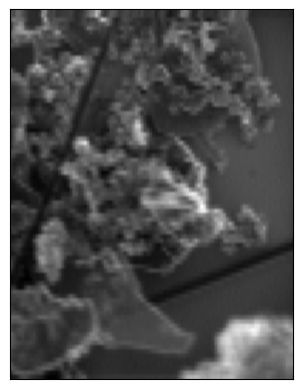

In [86]:
for i in range(0, data_trans.shape[2], 1):    
 layer=np.genfromtxt(filename1+f"{i:03d}.xim")
 data_tey[:,:,i]=layer
noscale(data_tey.sum(2), resox, resoy,'gray')
print('Total electron yield image')

### $$\textbf{Drift correction}$$
<hr>

shifts


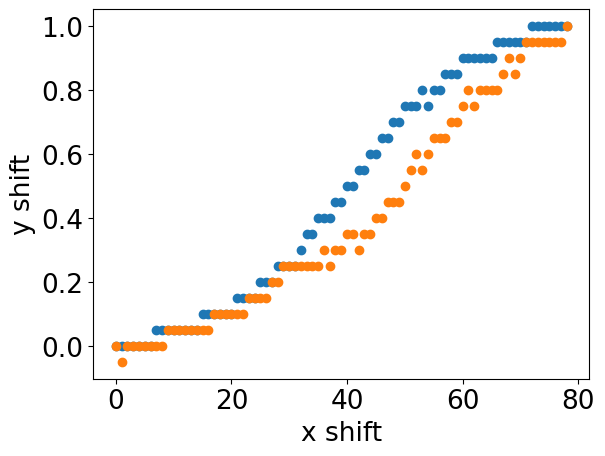

In [87]:
#aligning:https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html
shift=(alignment(data_trans))[0]
data_aligned=(alignment(data_trans))[1]
print('shifts')
plt.scatter(np.arange(0,shift[0].shape[0]),shift[0])
plt.scatter(np.arange(0,shift[1].shape[0]),shift[1])
plt.xlabel('x shift')
plt.ylabel('y shift')
data_tey_aligned=heteroalignment(data_tey, shift)

### $$\textbf{Conversion to optical density}$$
<hr>

Text(0.5, 0, 'Flux')

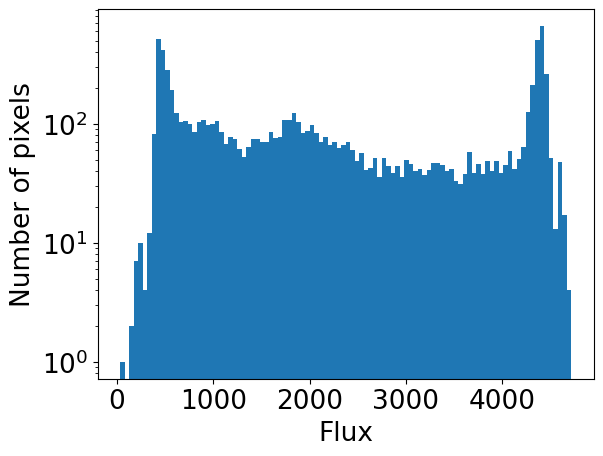

In [88]:
plt.hist(unfold(data_aligned).mean(1),100)
plt.yscale('log')
plt.ylabel('Number of pixels')
plt.xlabel('Flux')

Value 1 of the image signifies the background, meaning pixels with I>4400


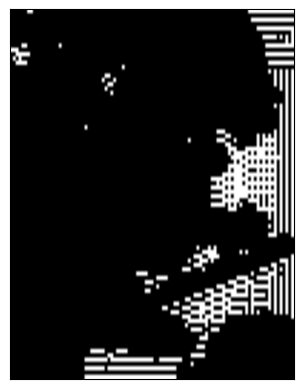

In [89]:
thresh=4400
print('Value 1 of the image signifies the background, meaning pixels with I>'+str(thresh))   
noscale(norm(data_aligned, thresh)[2].reshape(data_aligned.shape[0], data_aligned.shape[1]), resox, resoy, 'gray') 

In [90]:
data_trans_whitened = norm(data_aligned, thresh)[0]

### $$\textbf{Transmission spectrum, averaged over the whole area}$$
<hr>

(528.0, 550.0)

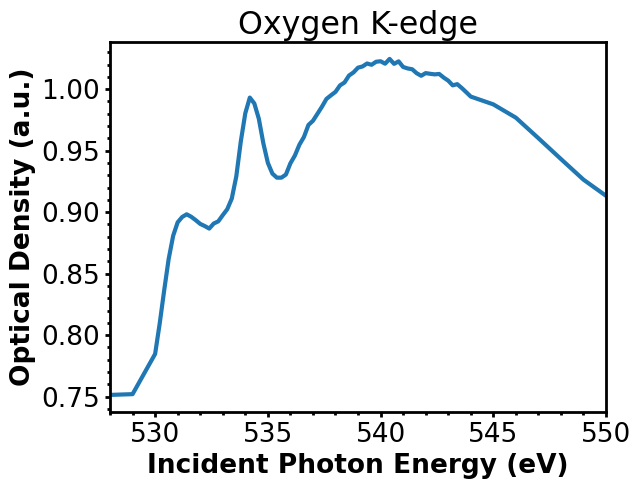

In [91]:
fig, ax2 = plt.subplots(1,1)
plt.plot(energy, (data_trans_whitened.reshape(data_trans_whitened.shape[0]* data_trans_whitened.shape[1], data_trans_whitened.shape[2]).mean(0)),linewidth=3)
plt.rcParams['font.size'] = '18'
plt.xlabel('Incident Photon Energy (eV)',weight="bold", fontsize=19)
matplotlib.rcParams.update({'font.size': 19})
plt.ylabel('Optical Density (a.u.)',weight="bold", fontsize=19)
plt.title('Oxygen K-edge')
plt.minorticks_on()
for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(2)
        ax2.tick_params(width=2)
        ax2.tick_params(width=2,which='minor')
plt.xlim([528,550])
#plt.ylim([0.62,2.4])

### $$\textbf{Clustering}$$
<hr>

Clustered Image
Mean Spectrum of each cluster


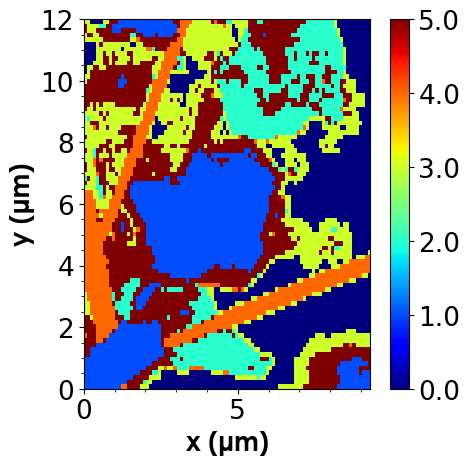

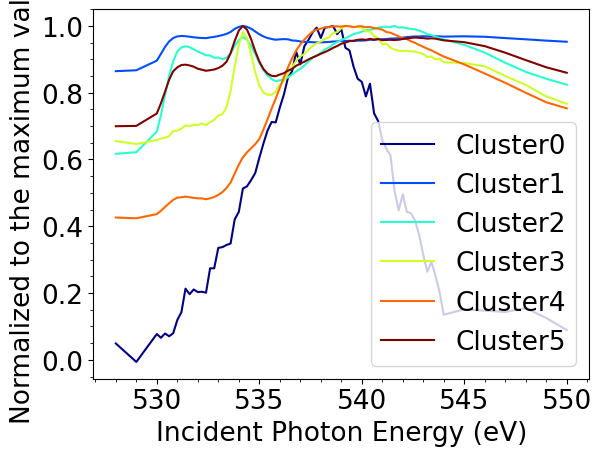

In [92]:
ans=clusteringopt(data_trans_whitened[3:-3,3:-3,:],6, False, energy, 'ICA', 'gmm')

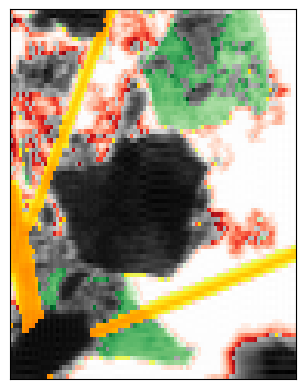

In [93]:
#cluster_per_pixelnew=ans[0]+1
data=data_trans_whitened[3:-3,3:-3,:]
noscale((-data.mean(2)), resox, resoy, 'gray')

c1=np.where(cluster_per_pixelnew!=1, 0,cluster_per_pixelnew )
c2=np.where(cluster_per_pixelnew!=2, 0,cluster_per_pixelnew )
c3=np.where(cluster_per_pixelnew!=3, 0,cluster_per_pixelnew )
c4=np.where(cluster_per_pixelnew!=4, 0,cluster_per_pixelnew )
c5=np.where(cluster_per_pixelnew!=5, 0,cluster_per_pixelnew )
c6=np.where(cluster_per_pixelnew!=6, 0,cluster_per_pixelnew )

n1 = masked_array(c1*data.mean(2), c1*data.mean(2) == 0)
n2 = masked_array(c2*data.mean(2), c2*data.mean(2) == 0)
n3 = masked_array(c3*data.mean(2), c3*data.mean(2) == 0)
n4 = masked_array(c4*data.mean(2), c4*data.mean(2) == 0)
n5 = masked_array(c5*data.mean(2), c5*data.mean(2) == 0)
n6 = masked_array(c6*data.mean(2), c6*data.mean(2) == 0) 

noscale(n3, resox, resoy,  'Greens')
noscale(n4, resox, resoy,  'Reds') 
noscale(n5, resox, resoy,  'Wistia') 

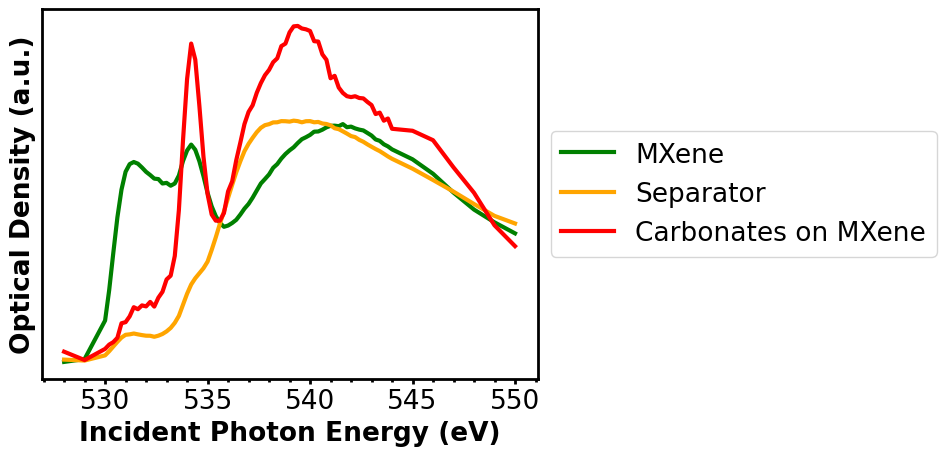

In [96]:
fig, ax2 = plt.subplots(1,1)
y1=-0.72+2.4*data.reshape(-1,data.shape[2])[ans[1][2]].mean(0)
y2=data.reshape(-1,data.shape[2])[ans[1][4]].mean(0)
y3=-1.5+9.9*data.reshape(-1,data.shape[2])[ans[1][3]].mean(0)
plt.plot(energy,-0.72+2.4*data.reshape(-1,data.shape[2])[ans[1][2]].mean(0),linewidth=3.0,color='green',label='MXene')
plt.plot(energy,data.reshape(-1,data.shape[2])[ans[1][4]].mean(0),linewidth=3.0,color='orange',label='Separator' )
plt.plot(energy,-1.5+9.9*data.reshape(-1,data.shape[2])[ans[1][3]].mean(0),linewidth=3.0,color='red',label='Carbonates on MXene' )
plt.rcParams['font.size'] = '18'
plt.xlabel('Incident Photon Energy (eV)',weight="bold", fontsize=19)
matplotlib.rcParams.update({'font.size': 19})
plt.ylabel('Optical Density (a.u.)',weight="bold", fontsize=19)
plt.minorticks_on()
for axis in ['top','bottom','left','right']:
        ax2.spines[axis].set_linewidth(2)
        ax2.tick_params(width=2)
        ax2.tick_params(which='minor', width=2)
plt.yticks([])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

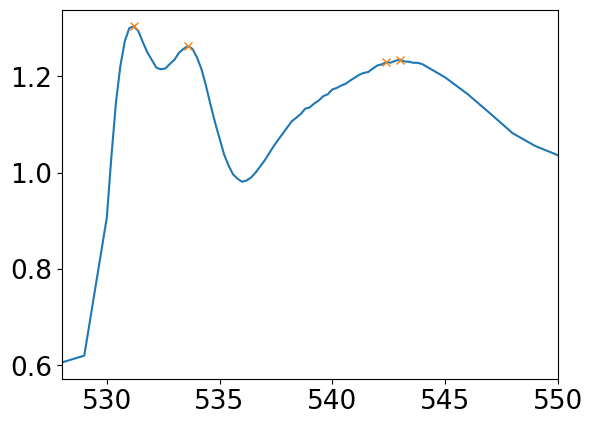

array([531.2, 533.6, 542.4, 543. ])

In [64]:
from scipy.signal import find_peaks
x=y_transok
energy=energy_pr_transok
peaks, _ = find_peaks(x, height=0)
plt.plot(energy,x)
plt.plot(energy[peaks],x[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.xlim([528,550])
plt.show()
energy[peaks]

# $$\textbf{Thank you for your attention.}$$